### Important
This code is used to plot the weather regimes, and also to remap the (random) clustering order from `01_WR_clustering_Bayes.py` to a standardised output, used in the rest of the scripts. This has to be manually adapted below via CLUSTER_REMAPPING to match the order given by CLUSTER_NAMES in `config.py`

### 1. Preliminaries

In [13]:
import ast
import os
from datetime import datetime

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import xarray as xr
from config_ERA5 import PATH_CLUSTERS, THRES, VERSION, CLUSTER_NAMES

In [16]:
centroids_real_space_raw = xr.open_dataarray(os.path.join(PATH_CLUSTERS, VERSION,
                                                      "centroids_unordered.nc"))
lons = centroids_real_space_raw.lon.to_numpy()
lats = centroids_real_space_raw.lat.to_numpy()
df_cluster_raw = pd.read_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_unordered.csv"))
df_cluster_raw["time"] = pd.to_datetime(df_cluster_raw["time"])

PATH_ED = "/usr/people/duinen/MSc-thesis/src/find_energydroughts/data/"
filename = "netto_demand_el7_winter_LENTIS_2023_PD_1600_events.csv"
df_ed = pd.read_csv(os.path.join(PATH_ED, filename))
df_ed["start_time"] = pd.to_datetime(df_ed["start_time"])
df_ed["end_time"] = pd.to_datetime(df_ed["end_time"])

### 2. Defining Functions

In [17]:
alphabet = ['(a)', '(b)', '(c)', '(d)']
def plot_clusters(df, centroids_real_space, z500_clim, lons, lats, cluster_names, ordered=True):
    """Plot zg500 clusters on a map.

    Parameters
    ----------
    df : DataFrame
        DataFrame containing cluster data.
    centroids_real_space : array-like
        Transformed cluster centers.
    z500_clim : array-like
        Climatological 500 hPa heights.
    lons : array-like
        Longitude values.
    lats : array-like
        Latitude values.
    cluster_names : list
        Names of the clusters.
    ordered : bool, optional
        Whether to order the clusters by name, by default True.
    """
    n_clusters = centroids_real_space.shape[0]
    levels_z500 = np.arange(5000, 6000, 100)

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-30, central_latitude=50)}, dpi=300)

    axs = axs.flatten()
    if ordered:
        titles = cluster_names
        titles[3] = "Atlantic Ridge"
    else:
        titles = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

    # only calc percentages for the first 4 clusters
    percentages = df.query("Bayes_cluster <= 3")['Bayes_cluster'].value_counts(normalize=True, sort=False).sort_index().to_list()
    
    for i, ax in enumerate(axs):
        if i < n_clusters:
            ax.set_extent([-90, 30, 20, 77.8], crs=ccrs.PlateCarree())
            
            # Does boundary with the correct shape
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 1.281944444], 0.314789
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T * radius + center
            temp = []
            for j in range(len(verts)):
                if verts[j][1]<1 :
                    temp.append([verts[j][0],1-(1-verts[j][1])*2.1])
            boundary = [[.36,1]]
            boundary.extend(temp[::-1])
            boundary.extend([[.64,1],[1,.275]])
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 1.281944444], 1.281944444
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T * radius + center
            temp = []
            for j in range(len(verts)):
                if verts[j][1]<0.275 and verts[j][0]<1 and verts[j][0]>0:
                    temp.append([verts[j][0],verts[j][1]*2.7])
            boundary.extend(temp)
            boundary.extend([[0,.275]])
            boundary = mpath.Path(boundary)
            ax.set_boundary(boundary, transform=ax.transAxes)

            fill = ax.contourf(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend="both",
                transform=ccrs.PlateCarree())

            CS = ax.contour(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze() + z500_clim,
                levels=levels_z500,
                colors=".25",
                linewidths=1,
                transform=ccrs.PlateCarree())
            ax.clabel(CS, inline=True, fontsize=10)
            
            ax.coastlines(resolution="110m")
            ax.set_title(f"{alphabet[i]} {titles[i]}")

            ax.text(35,70, f"{round(100*percentages[i])}%",fontsize=12, transform=ccrs.Geodetic())

    ypos = .05
    xpos = 0.165
    xlen = 0.7
    ylen = 0.025
    cbar_ax = fig.add_axes([xpos, ypos, xlen, ylen])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation="horizontal", label="500 hPa height anomaly [m]", extend="both", ticks=np.arange(-200, 250, 50))

    plt.show()

In [18]:
def plot_clusters_v0(df, centroids_real_space, z500_clim, lons, lats, cluster_names, ordered = True):
    """Plot zg500 clusters on a map.

    Parameters
    ----------
    - centroids_real_space: Transformed cluster centers.
    - lons, lats: Longitude and Latitude values.

    """
    n_clusters = centroids_real_space.shape[0]
    levels_z500 = np.arange(5000, 6000, 80)

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-30, central_latitude=50)})

    axs = axs.flatten()
    if ordered:
        titles = cluster_names
    else:
        titles = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

    percentages = df['Bayes_cluster'].value_counts(normalize = True, sort = False).sort_index().to_list()
    for i, ax in enumerate(axs):
        if i < n_clusters:
            ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()],
                          crs=ccrs.PlateCarree())
            fill = ax.contourf(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend="both",
                transform=ccrs.PlateCarree())
            #TODO: For EGU contours off!
            # CS = ax.contour(
            #     lons,
            #     lats,
            #     centroids_real_space[i, :, :].squeeze() + z500_clim,
            #     levels=levels_z500,
            #     colors="k",
            #     linewidths=1,
            #     transform=ccrs.PlateCarree())
            # ax.clabel(CS, inline=True, fontsize=10)
            ax.coastlines(resolution="50m")
            ax.gridlines()
            #TODO: For EGU no percentage in title!
            # ax.set_title(f"{titles[i]} ({100 * percentages[i]:.2f}%)", fontsize=12)
            ax.set_title(f"{titles[i]}")

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation="vertical", label="500 hPa height anomaly [m]", extend="both", ticks=np.arange(-200, 250, 50))


In [19]:
def plot_bayes(df_cluster, year, run):
    """Plot timeseries of Bayes parameters, make hard assignment."""
    date_begin = datetime(year - 1, 11, 1, 9)  # November 1st of the season_begin year
    date_end = datetime(year, 3, 31, 9)  # March 31st of the year

    # Perform the query and get the DataFrame
    tbegin = df_cluster.query("run == @run and time >= @date_begin").index.min()
    tend = df_cluster.query("run == @run and time <= @date_end").index.max()

    cluster_subset = df_cluster.loc[tbegin:tend]

    time = cluster_subset["time"]
    prior = np.array(cluster_subset["prior"].tolist())
    likelihood = np.array(cluster_subset["likelihood"].tolist())
    post = np.array(cluster_subset["posterior"].tolist())
    wri = np.array(cluster_subset["wri"].tolist())

    hard_assignment = cluster_subset["Bayes_cluster"].to_numpy()
    original_clusters = cluster_subset["raw_cluster_id"].to_numpy()

    fig, axs = plt.subplots(
        6,
        1,
        sharex=True,
        figsize=(8, 12),
        gridspec_kw={"height_ratios": [3, 3, 3, 0.1, 0.1, 3]},
        dpi = 300,
    )

    for i, cluster in enumerate(CLUSTER_NAMES):
        axs[0].plot(time, prior[:, i], label=cluster)
        axs[1].plot(time, likelihood[:, i], label=cluster)
        axs[2].plot(time, post[:, i], label=cluster)

    axs[0].set_ylabel("Prior")
    axs[1].set_ylabel("Likelihood")
    axs[2].set_ylabel("Posterior")
    axs[2].axhline(y=THRES, color="gray", linestyle="--", label="Threshold")

    # Add 'hard assignment' plot with colored dots
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:gray",
    ] 
    hard_assignment_color = [
        colors[hard_assignment[idx]]
        for idx in range(len(hard_assignment))
    ]
    original_clusters_color = [
        colors[original_clusters[idx]]
        for idx in range(len(original_clusters))
    ]

    # Add 'hard assignment' plot with colored bar charts
    bar_height = 0.2
    for t, color in zip(time, hard_assignment_color):
        axs[3].bar(t, bar_height, color=color, width=1, align="center")
    for t, color in zip(time, original_clusters_color):
        axs[4].bar(t, bar_height, color=color, width=1, align="center")

    axs[3].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[3].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[3].set_ylabel("Hard")

    axs[4].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[4].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[4].set_ylabel("Def.")

    for i in range(wri.shape[1]):
        axs[5].plot(time, wri[:,i])

    axs[5].axhline(y=1, color="gray", linestyle="--", label="Threshold")
    axs[5].set_ylabel(r"WRI $[\sigma]$")

    axs[0].legend(loc="upper right")  # Adjust the location of the overall legend
    plt.tight_layout()

In [20]:
def plot_bayes_small(df_cluster, df_events, year, run):
    """Plot timeseries of Bayes parameters, make hard assignment."""
    date_begin = datetime(year - 1, 11, 1, 9)  # November 1st of the season_begin year
    date_end = datetime(year, 3, 31, 9)  # March 31st of the year

    # Perform the query and get the DataFrame
    tbegin = df_cluster.query("run == @run and time >= @date_begin").index.min()
    tend = df_cluster.query("run == @run and time <= @date_end").index.max()

    cluster_subset = df_cluster.loc[tbegin:tend]
    runs = f'h{run:03d}'
    events = df_ed.query("runs == @runs and start_time >= @date_begin and end_time <= @date_end")

    time = cluster_subset["time"]
    post = np.array(cluster_subset["posterior"].tolist())
    wri = np.array(cluster_subset["wri"].tolist())

    hard_assignment = cluster_subset["Bayes_cluster"].to_numpy()

    fig, axs = plt.subplots(
        4,
        1,
        sharex=True,
        figsize=(8, 12),
        gridspec_kw={"height_ratios": [3, 0.1, 3, 3]},
    )

    for i, cluster in enumerate(CLUSTER_NAMES):
        axs[0].plot(time, post[:, i], label=cluster)

    axs[0].set_ylabel("Posterior")
    axs[0].axhline(y=THRES, color="gray", linestyle="--", label="Threshold")

    # Add 'hard assignment' plot with colored dots
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:gray",
    ]
    hard_assignment_color = [
        colors[hard_assignment[idx]]
        for idx in range(len(hard_assignment))
    ]

    # Add 'hard assignment' plot with colored bar charts
    bar_height = 0.2
    for t, color in zip(time, hard_assignment_color):
        axs[1].bar(t, bar_height, color=color, width=1, align="center")


    axs[1].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[1].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[1].set_ylabel("Hard")

    for i in range(wri.shape[1]):
        axs[2].plot(time, wri[:,i])

    axs[2].axhline(y=1, color="gray", linestyle="--", label="Threshold")
    axs[2].set_ylabel(r"WRI $[\sigma]$")

    axs[3].hist(pd.to_datetime(events['start_time']), align = 'right', bins = pd.date_range(start=date_begin, end=date_end, freq='W'))

    axs[0].legend(loc="upper right")  # Adjust the location of the overall legend
    plt.tight_layout()

In [21]:
def plot_bayes_small_nohist(df_cluster, df_events, year, run):
    """Plot timeseries of Bayes parameters, make hard assignment."""
    date_begin = datetime(year - 1, 11, 1, 9)  # November 1st of the season_begin year
    date_end = datetime(year, 3, 31, 9)  # March 31st of the year

    # Perform the query and get the DataFrame
    tbegin = df_cluster.query("run == @run and time >= @date_begin").index.min()
    tend = df_cluster.query("run == @run and time <= @date_end").index.max()

    cluster_subset = df_cluster.loc[tbegin:tend]
    runs = f'h{run:03d}'
    events = df_ed.query("runs == @runs and start_time >= @date_begin and end_time <= @date_end")

    time = cluster_subset["time"]
    post = np.array(cluster_subset["posterior"].tolist())
    wri = np.array(cluster_subset["wri"].tolist())

    hard_assignment = cluster_subset["Bayes_cluster"].to_numpy()

    fig, axs = plt.subplots(
        3,
        1,
        sharex=True,
        figsize=(8, 10),
        gridspec_kw={"height_ratios": [3, 0.1, 3]},
    )

    for i, cluster in enumerate(CLUSTER_NAMES):
        axs[0].plot(time, post[:, i], label=cluster)

    axs[0].set_ylabel("Posterior")
    axs[0].axhline(y=THRES, color="gray", linestyle="--", label="Threshold")

    # Add 'hard assignment' plot with colored dots
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:gray",
    ]
    hard_assignment_color = [
        colors[hard_assignment[idx]]
        for idx in range(len(hard_assignment))
    ]

    # Add 'hard assignment' plot with colored bar charts
    bar_height = 0.2
    for t, color in zip(time, hard_assignment_color):
        axs[1].bar(t, bar_height, color=color, width=1, align="center")


    axs[1].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[1].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[1].set_ylabel("Hard")

    for i in range(wri.shape[1]):
        axs[2].plot(time, wri[:,i])

    axs[2].axhline(y=1, color="gray", linestyle="--", label="Threshold")
    axs[2].set_ylabel(r"WRI $[\sigma]$")

    axs[0].legend(loc="upper right")  # Adjust the location of the overall legend
    plt.tight_layout()

### 3. Plotting

In [22]:
z500 = xr.open_dataarray("/usr/people/duinen/MSc-thesis/Data/clim_zg500_v1.nc")
z500 = z500.where(
        (z500["lon"] < 30) &
        (z500["lat"] > 20) &
        (z500["lat"] < 80) &
        ((z500["dayofyear"] > 304) | (z500["dayofyear"] < 91)),
)

z500 = z500.sel(lon=slice(None, 30), lat=slice(20, 80))
z500_coarse = z500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = "trim").mean()
z500_clim = z500_coarse.mean(dim = "dayofyear", skipna = True)

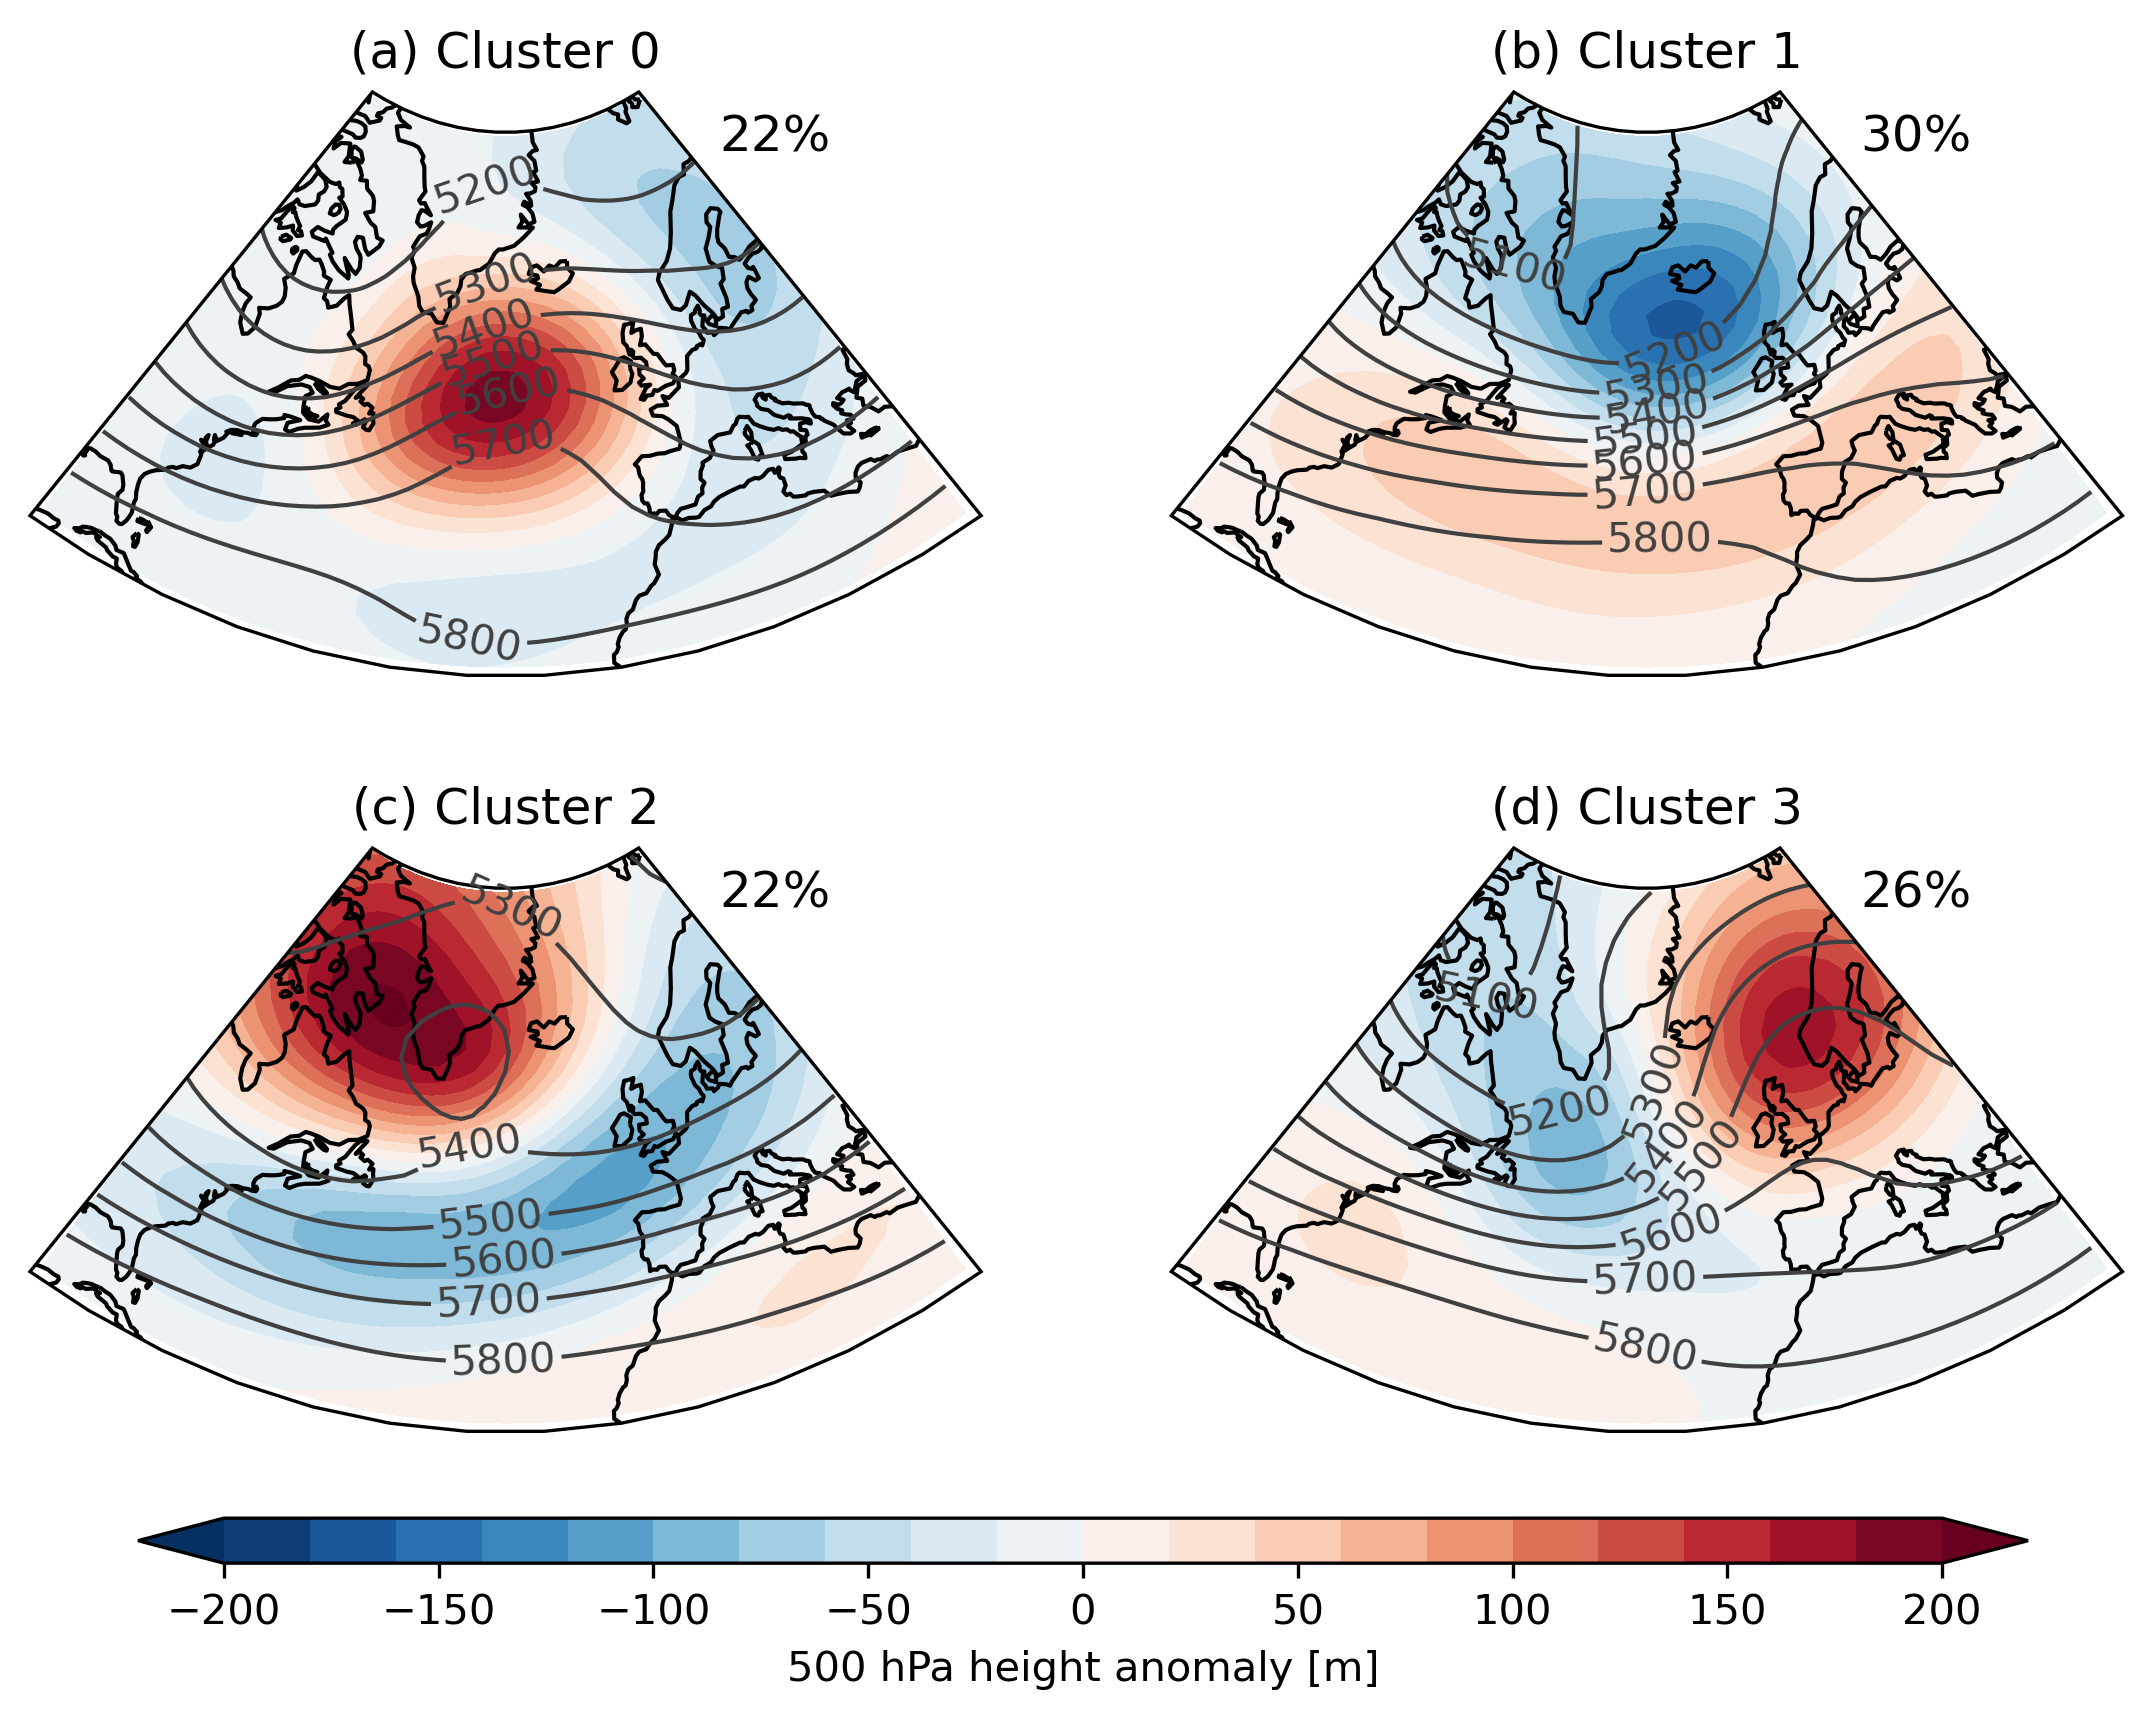

In [23]:
#TODO: isobars should really be calculated and shown for each day; now anomaly wrt average over whole winter. Thats not right
plot_clusters(df_cluster_raw, centroids_real_space_raw, z500_clim, lons, lats, CLUSTER_NAMES, ordered = False)

In [24]:
#ERA Version
def remap_lists(df, df_raw, column, mapping):
    column_arr = np.array(df_raw[column].apply(ast.literal_eval).tolist(), dtype = float)
    column_reshape = column_arr[:, list(mapping.values())[:4]]
    df[column] = column_reshape.tolist()
    return df


CLUSTER_REMAPPING = {0: 1, 1: 2, 2: 3, 3: 0, 4: 4} # make sure to change after new clustering run!
df_cluster = pd.DataFrame()
df_cluster['time'] = df_cluster_raw['time'].copy()
df_cluster['Bayes_cluster'] = df_cluster_raw['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_cluster['Bayes_cluster_raw'] = df_cluster_raw['Bayes_cluster_raw'].map(CLUSTER_REMAPPING)
df_cluster['raw_cluster_id'] = df_cluster_raw['cluster_id'].map(CLUSTER_REMAPPING)

df_cluster = remap_lists(df_cluster, df_cluster_raw, "prior", CLUSTER_REMAPPING)
df_cluster = remap_lists(df_cluster,  df_cluster_raw, "likelihood", CLUSTER_REMAPPING)
df_cluster = remap_lists(df_cluster,  df_cluster_raw, "posterior", CLUSTER_REMAPPING)
df_cluster = remap_lists(df_cluster,  df_cluster_raw, "wri", CLUSTER_REMAPPING)
centroids_real_space = centroids_real_space_raw[list(CLUSTER_REMAPPING.values())[:4], :, :]


In [25]:
#LENTIS Version, ERA remapping
def remap_lists(df, df_raw, column, mapping):
    column_arr = np.array(df_raw[column].apply(ast.literal_eval).tolist(), dtype = float)
    column_reshape = column_arr[:, list(mapping.values())[:4]]
    df[column] = column_reshape.tolist()
    return df

#BUG: I think the mapping inside the dictionary and the lists should be done differently, now fixed manually
CLUSTER_REMAPPING = {0: 1, 3: 2, 2: 3, 1: 0, 4: 4} # make sure to change after new clustering run!
CLUSTER_REMAPPING_centroids = {0: 1, 1: 2, 2: 3, 3: 0, 4: 4} # make sure to change after new clustering run!

df_cluster = df_cluster_raw.copy()
df_cluster['Bayes_cluster'] = df_cluster_raw['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_cluster['Bayes_cluster_raw'] = df_cluster_raw['Bayes_cluster_raw'].map(CLUSTER_REMAPPING)
df_cluster['raw_cluster_id'] = df_cluster_raw['cluster_id'].map(CLUSTER_REMAPPING)

remap_lists(df_cluster, df_cluster_raw, "prior", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "likelihood", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "posterior", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "wri", CLUSTER_REMAPPING)
centroids_real_space = centroids_real_space_raw[list(CLUSTER_REMAPPING_centroids.values())[:4], :, :]


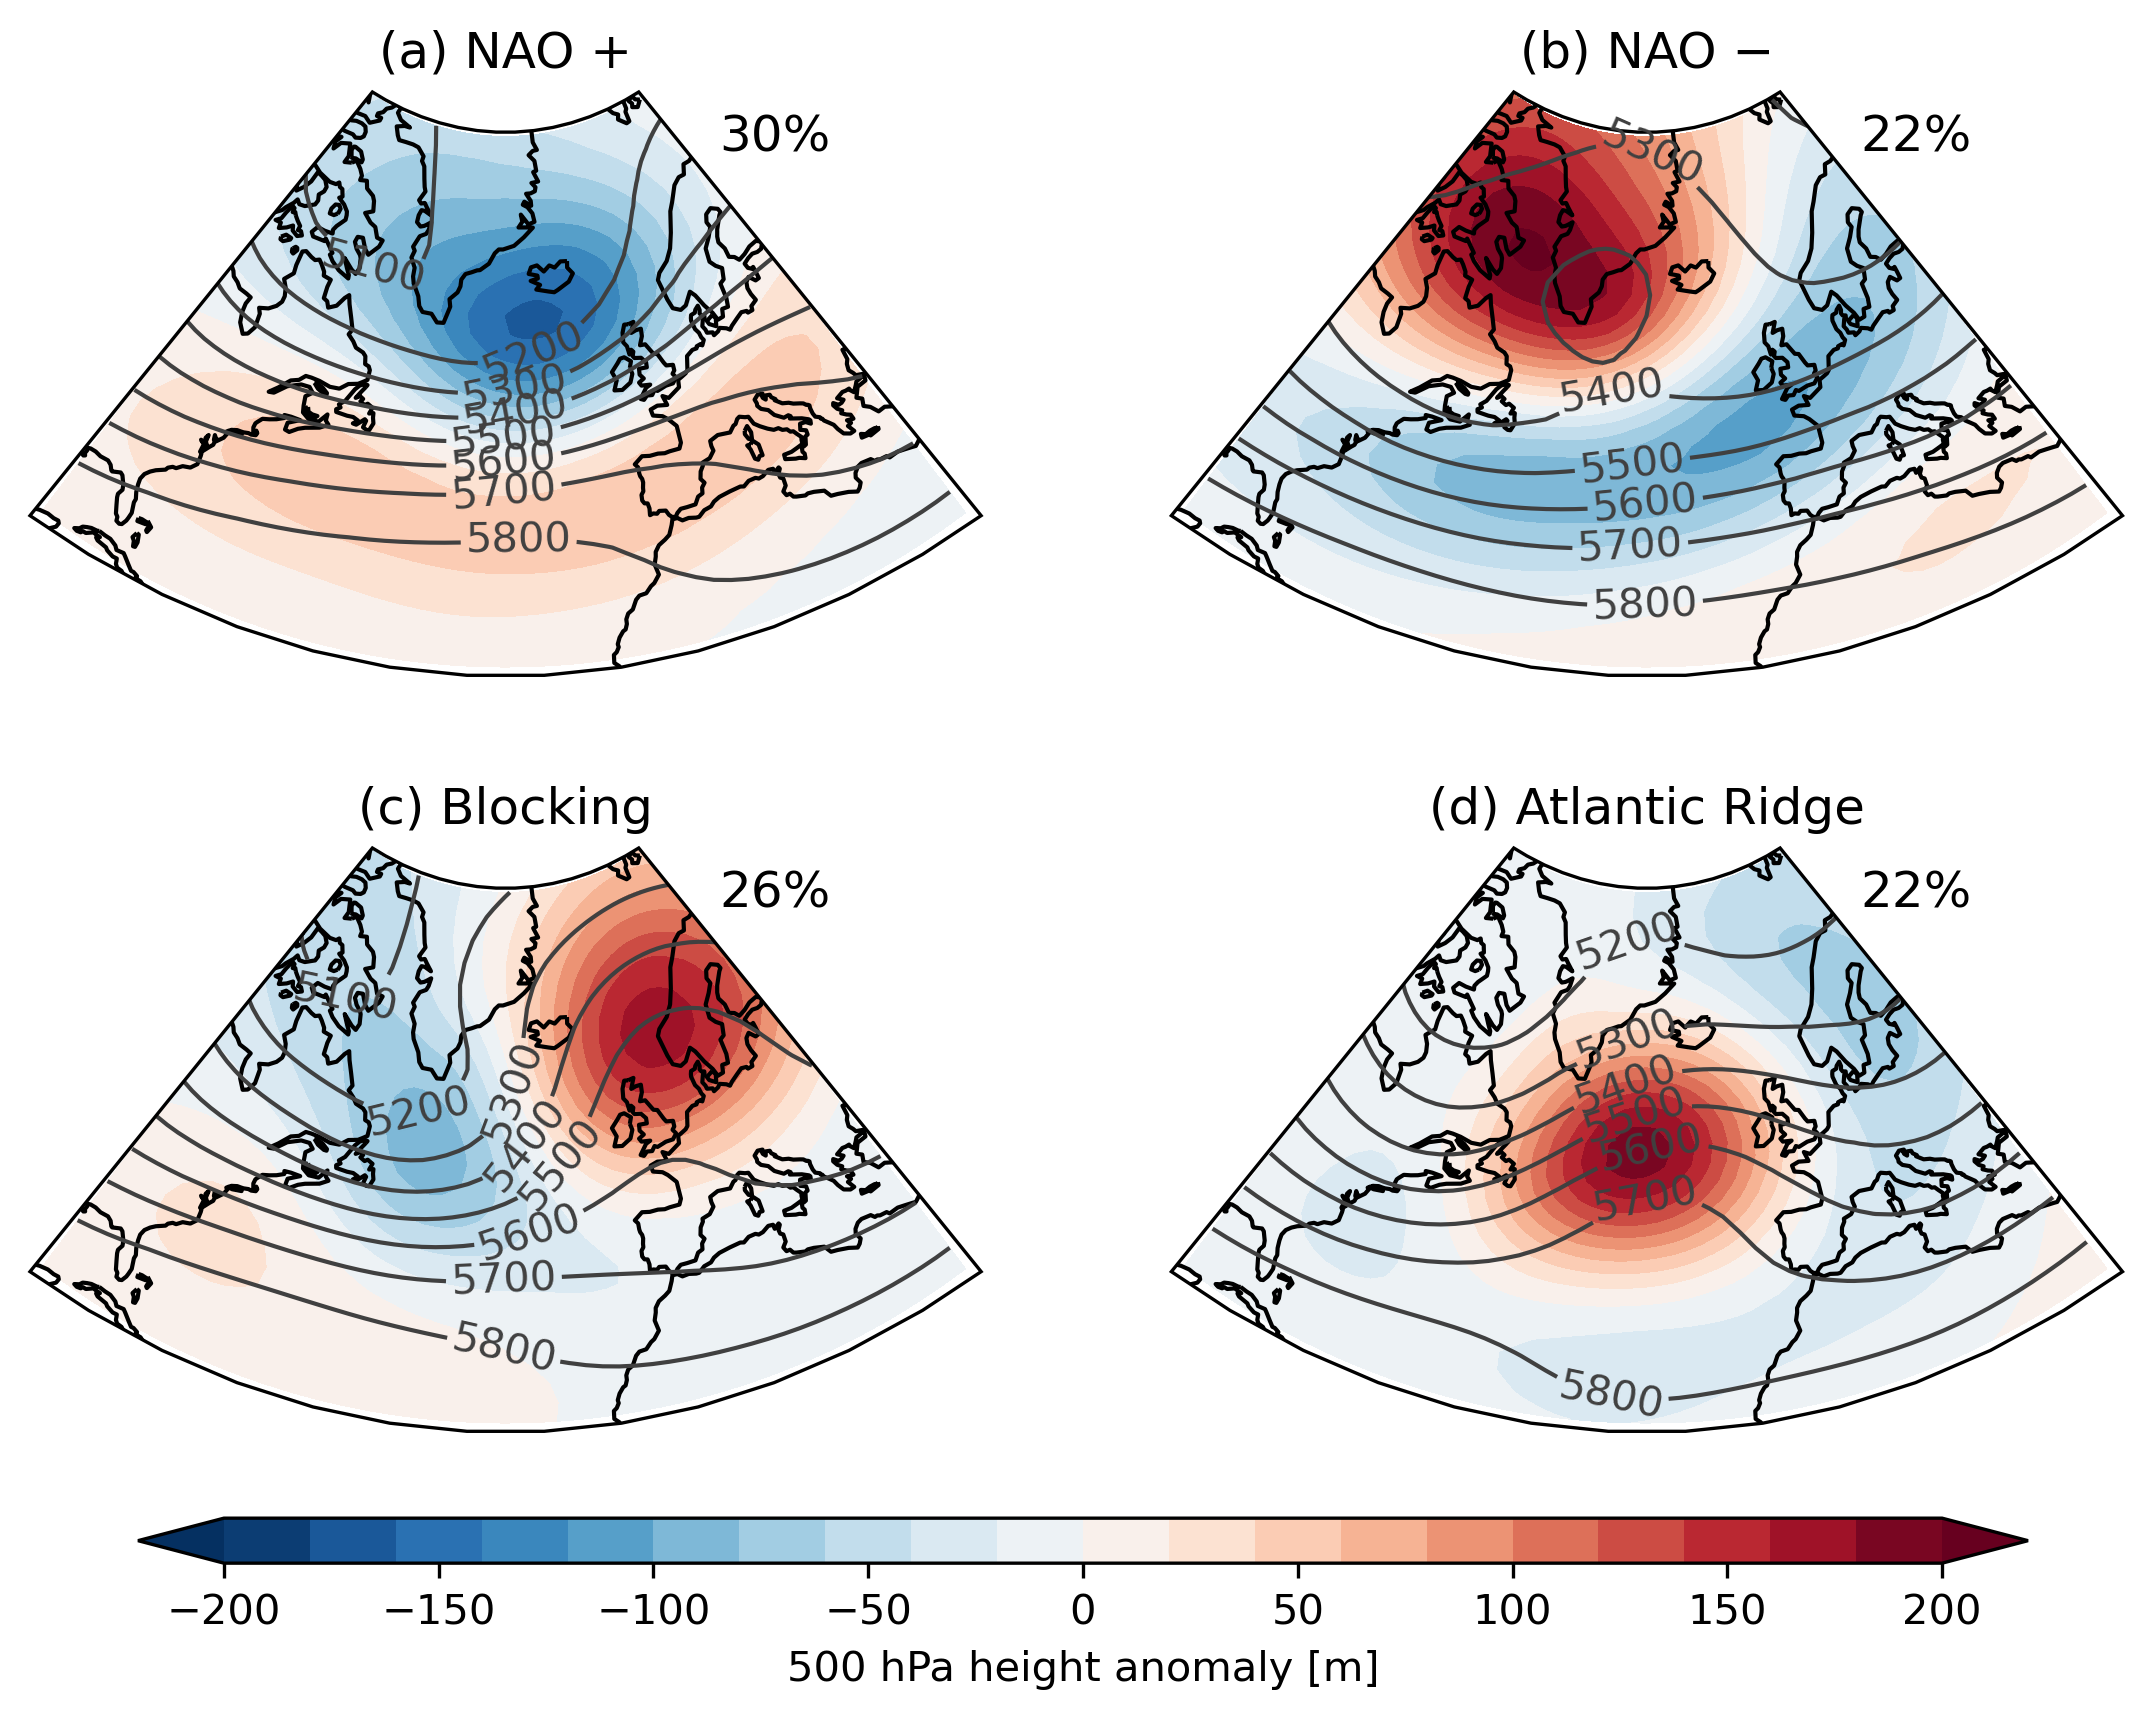

In [26]:
plot_clusters(df_cluster, centroids_real_space, z500_clim, lons, lats, CLUSTER_NAMES, ordered = True)
#plt.savefig("../../Results/Figures/clusters_ERA5_ordered.png", dpi = 300, bbox_inches = "tight")

In [33]:
df_cluster.to_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_ordered.csv"), index = False)
centroids_real_space.to_netcdf(os.path.join(PATH_CLUSTERS, VERSION, "centroids_ordered.nc"))

In [18]:
VERSION_LENTIS = "Bayes_full_v2"
centroids_lentis = xr.open_dataarray(os.path.join(PATH_CLUSTERS, VERSION_LENTIS, "centroids_ordered.nc"))

In [20]:
CLUSTER_NAMES

['NAO +', 'NAO -', 'Blocking', 'Atl. Ridge']

In [21]:
for i in range(4):
    print(CLUSTER_NAMES[i], np.corrcoef(centroids_real_space[i].values.flatten(), centroids_lentis[i].values.flatten())[0, 1])

NAO + 0.9569605814650428
NAO - 0.9790476091787519
Blocking 0.8445703401493658
Atl. Ridge 0.9385494513408007


### Appendix

In [ ]:
wri = np.array(df_cluster['wri'].tolist())

In [ ]:
np.arange(-4, 5)

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

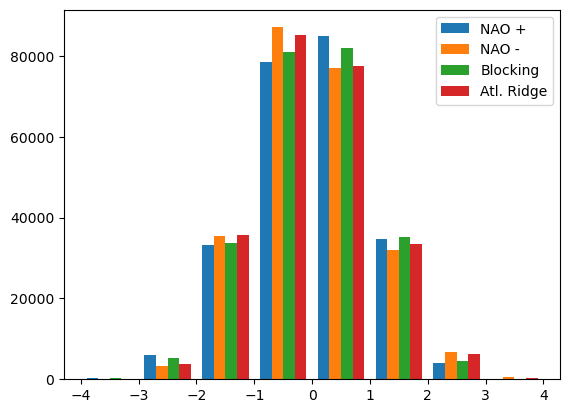

In [ ]:
plt.hist(wri, label = CLUSTER_NAMES, bins = np.arange(-4, 5))
plt.legend()

In [ ]:
events = df_ed.query("runs == 'h035' and start_time > '2001-10-31' and end_time < '2002-04-01'")

In [ ]:
df_ed

,Unnamed: 0,event_number,runs,start_time,end_time,country
0,0,1,h061,2003-12-26 12:00:00,2004-01-01 12:00:00,AUT
1,1,2,h068,2004-12-20 12:00:00,2004-12-26 12:00:00,AUT
2,2,3,h036,2006-12-14 12:00:00,2006-12-20 12:00:00,AUT
3,3,4,h072,2003-12-13 12:00:00,2003-12-19 12:00:00,AUT
4,4,5,h072,2001-12-14 12:00:00,2001-12-20 12:00:00,AUT
...,...,...,...,...,...,...
46395,46395,1596,h166,2006-01-10 12:00:00,2006-01-16 12:00:00,UKR
46396,46396,1597,h046,2003-11-13 12:00:00,2003-11-19 12:00:00,UKR
46397,46397,1598,h103,2001-01-31 12:00:00,2001-02-06 12:00:00,UKR
46398,46398,1599,h070,2001-01-27 12:00:00,2001-02-02 12:00:00,UKR


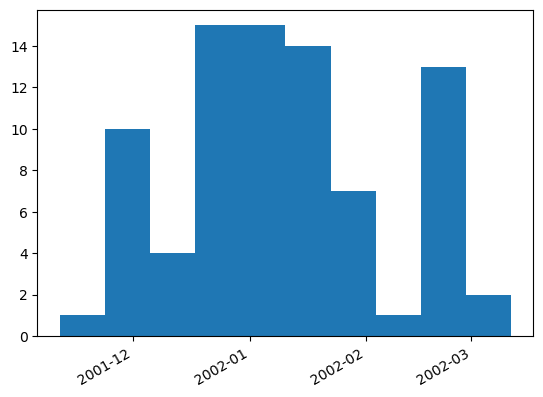

In [ ]:
import matplotlib.dates as mdates

plt.hist(pd.to_datetime(events['start_time']), bins = 10)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set xticks to be monthly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format xticks as 'YYYY-MM'
plt.gcf().autofmt_xdate()  # rotate xticks for readability